In [40]:
import os, sys
from logging import setLogRecordFactory

stage1_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if stage1_dir not in sys.path:
    sys.path.insert(0, stage1_dir)

## Generative Pretrained Transformer (GPT) ModeL
Now that we understand the attention mechanism, one of the core components of traditional LLMs, we can now put this mechanism in the context of other building blocks, which we can then put together to end up with our own GPT model. Up to this point, we have been keeping embedding dimensionality small in the interest of easier learning and understanding. Now we will attempt to scale everything up to a scale comparable to the smallest GPT-2 model (124 million parameters).

#### *Language Models are Unsupervised Multitask Learners (Radford et.al, 2019)*
This paper first introduced GPT-2, the largest model of which achieved, at the time, state-of-the-art results in 7 out of 8 tested language modeling datasets in a zero-shot setting. It represented a huge step towards building language models that could be accurately characterized as 'competent generalists', rather than 'narrow experts', systems that could perform tasks (sentiment analysis, translation, entity extraction, etc.) without the need to create and label a separate training set for each one.

The standard definition of a language model is an unsupervised probability distribution that is fitted over token sequences. Given a corpus of sequences:

$$
\{\,x^{(j)} = (s_1^{(j)}, s_2^{(j)}, \dots, s_{n_j}^{(j)})\}_{j=1}^N.
$$

We maximize the log-likelihood
$$
\mathcal{L} = \sum_{j=1}^N \log p\bigl(x^{(j)}\bigr),
$$

where
$$
p(x) = \prod_{i=1}^{n} p\bigl(s_i \mid s_{<i}\bigr).
$$

Recent architectures, like the Transformer with its self-attention, compute and parametrize each conditional $p(s_i \mid s_{<i})$ and dramatically increase expressivity. Therefore, learning to perform a single task can be ordinarily modeled as an estimation of a distribution $p(\text{output}\mid\text{input})$. A general solver must however also condition on which task to perform $p(\text{output}\mid\text{input, task})$. Up to this point, task conditioning in the context of multitask settings was implemented at an architectural level: task specific encoders and decoders, at an algorithmic level with meta-learning loops, etc. The paper's hypothesis was that **unsupervised multitask learning via pure language modeling was possible.**

> When a large language model is trained on a sufficiently large and diverse dataset it is able to perform well across many domains and datasets. [...] high-capacity models trained to maximize the likelihood of a sufficiently varied text corpus begin to learn how to perform a surprising amount of tasks without the need for explicit supervision.
>
>--<cite>Language Models are Unsupervised Multitask Learners, Radford et.al, 2019</cite>


In [41]:
from nltk.draw import cfg
from transformers.utils.fx import torch_flip
from dataclasses import dataclass

@dataclass
class GPTConfig124:
    vocab_size: int = 50257
    context_length: int = 1024
    emb_dim: int = 768
    n_heads: int = 12
    n_layers: int = 12
    dropout: float = 0.1
    qkv_bias: bool = False


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPT2Dummy(nn.Module):
    """
    A *do nothing* GPT2 scaffold.
    We will progressively accordingly swap nn.Identity for real implementations.
    """
    def __init__(self, cfg: GPTConfig124):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.emb_dim)
        self.pos_emb = nn.Embedding(cfg.context_length, cfg.emb_dim)
        self.drop_emb = nn.Dropout(cfg.dropout)
        self.blocks = nn.ModuleList(
            [nn.Identity() for _ in range(cfg.n_layers)]
        )
        self.norm = nn.Identity()
        self.lm_head = nn.Linear(cfg.emb_dim, cfg.vocab_size, bias=False)

    def forward(self, in_idx: torch.Tensor):
        """
        idx: (batch_size, seq_len) tensor of token indices.
        :return: logits: (batch_size, seq_len, vocab_size) tensor of logits (unnormalized scores).
        """
        B, T = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(T, device=in_idx.device))
        x = self.drop_emb(tok_embeds + pos_embeds)
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        logits = self.lm_head(x)
        return logits


- `self.tok_emb`, `self.pos_emb` turn discrete tokens and positions into continuous vectors of size `emb_dim`.
- `self.blocks`, collected in a `nn.ModuleList` is where the attention & multilayer perceptron layers would normally live. Each block is currently a no-op; it simply returns its input.
- `self.norm` is also a placeholder that does nothing. GPT-2 applies a Layernorm after the stack of the blocks.
- `nn.Linear` with `bias=False` projects the final hidden states back to vocabulary size so we can compute logits for the next-token predictions.
- The forward pass therefore embeds tokens and positions -> adds them -> adds dropout -> passes through blocks -> layer-norm -> linear head. It mirrors the high-level flow of a real GPT-2, just without any real computations inside the blocks.

In [43]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')
batch = []

text = """A man told me once that all the bad people
Were needed. Maybe not all, but your fingernails
You need; they are really claws, and we know
Claws. The sharks--what about them?
They make other fish swim faster. The hard-faced men
In black coats who chase you for hours
In dreams--that's the only way to get you
To the shore. Sometimes those hard women
Who abandon you get you to say, "You."
A lazy part of us is like a tumbleweed.
It doesn't move on its own. It takes sometimes
A lot of Depression to get tumbleweeds moving.
Then they blow across three or four States.
This man told me that things work together.
Bad handwriting sometimes leads to new ideas;
And a careless God--who refuses to let you
Eat from the Tree of Knowledge--can lead
To books, and eventually to us. We write
Poems with lies in them, but they help a little."""

tokens = tokenizer.encode(text)
tokens.append(tokenizer.eot_token)

print(tokens[:5])

B, T = 2, 4
data = torch.tensor(tokens[:8+1])

x = data[:-1].view(B,T) #input tensor
y = data[1:].view(B,T) #target tensor for next token prediction

batch.append(x)

print(x)
print(y)
print(batch[0])


[32, 582, 1297, 502, 1752]
tensor([[  32,  582, 1297,  502],
        [1752,  326,  477,  262]])
tensor([[ 582, 1297,  502, 1752],
        [ 326,  477,  262, 2089]])
tensor([[  32,  582, 1297,  502],
        [1752,  326,  477,  262]])


|             ![Full GPT-2 Architecture](../images/full_architecture.png)             |
|:--------------------------------------------------------------------------------:|
| *GPT-2 Architecture* (GPT-2 Detailed Model Architecture, **Henry Wu** on Medium) |

In [44]:
torch.manual_seed(123)
model = GPT2Dummy(GPTConfig124)
logits = model(x)
print(f'Output shape:\n {logits.shape}')
print(f'Logits:\n{logits}')

Output shape:
 torch.Size([2, 4, 50257])
Logits:
tensor([[[ 0.3944, -0.0408, -0.2424,  ..., -0.2212,  0.0131,  1.3445],
         [-0.6989,  0.2696, -0.5769,  ..., -0.2170,  0.0857, -0.0557],
         [ 0.8880,  0.1022,  0.5163,  ...,  0.7871,  0.9948,  0.7927],
         [ 0.0979,  0.5000, -0.9337,  ...,  1.7114,  0.3513, -0.3061]],

        [[-0.1601, -0.8575, -0.5662,  ...,  0.3182, -1.2915, -0.2427],
         [-1.3554,  1.2148, -0.4383,  ..., -0.5768,  0.1907,  0.6106],
         [-0.5857,  0.6561,  0.0237,  ...,  1.3546, -0.2586, -1.0205],
         [ 0.1957, -0.2056, -0.4146,  ...,  2.6419, -0.4892, -0.1127]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has two "blocks" corresponding to the two text samples (two batches). Each sample consists of 4 tokens, and each token is mapped to a 50257-dimensional vector, one for each word in our dictionary. There are two blocks, each block has 4 rows, each row has 50257 columns.

## Layer Normalization *(Layer Normalization (Lei Ba et.al, 2016))*

Vanishing or exploding gradients are a common problem when training deep neural networks. They lead to instability in the training process, and make it difficult for the network to find a set of parameters that can robustly minimize the loss function. In the original Transformer architecture (*Attention is All You Need*, Vaswani et al., 2017, a paper already introduced in our attention exploration) layer normalization was placed between the residual blocks. In GPT-2, layer normalization is applied before and after residual blocks, and before the final output layer.

> A *residual block* augments a sub-layer (e.g. self-attention or feed-forward network) with a shortcut connection that simply adds the block's input to its output. If $S(\bullet)$ denotes the sub-layer transformation on input $x$, the block yields $y = x + S(x)$. This connection encourages the network to learn perturbations around the identity function, making very deep architectures trainable. In the original architecture, each attention or feed-forward sub-layer is followed by a residual addition and then layer normalization.

|              ![Transformer Model Architecture](../images/transformerarch.png)              |
|:---------------------------------------------------------------------------------------:|
| *Original Transformer Architecture* (*Attention is All You Need, Vaswani et al., 2017*) |

*Layer normalization* is an evolution of *batch normalization*, which first appeared as a method to speed up the learning of deep neural networks, which would often require many days. Batch normalization standardized summed input using its mean and its standard deviation across the training data, and it led to **to faster converging, faster training time and the randomness from batch statistics also served as regularization during training, reducing variance.**

Batch normalization is also designed to reduce undesirable *covariate shift*. This occurs when the gradients with respect to weights in one layer are highly affected on the outputs from previous layers. In deep neural networks, the updates in the earlier layers' weights during training will change the input distribution of the following layers. Indeed, covariate shift can be mitigated by different normalization techniques.

However, as already mentioned, batch normalization requires averaging summed input statistics. **This is efficient and straightforward in feed-forward networks with fixed depth, where the length of inputs does not vary.** In problems where the summed inputs often vary with the length of the input sequence, each distinct time-step might require different statistics. Therefore, while batch normalization is applied over the batch dimension independently for each feature index, layer normalization is applied over $d_{model}$ (in this case, our 50257-dimensional vector) only, independently for each $(\text{batch}, \text{token})$ pair.

|                      ![Batch Normalization](../images/batchNorm.png)                      |
|:--------------------------------------------------------------------------------------:|
| Batch Norm Visualized (*Layer Normalization in Transformer*, **Sachinsoni** on Medium) |

> In principle, one could pad every sequence in a batch to the same length and then apply batch normalization at each time step, maintaining separate mean/variance statistics for each position. However, there are a lot of drawbacks introduced by this strategy:
>
> - padding shorter sequences up to a given length involves performing more computations.
> - introducing padding may introduce a lot of zeros into the dataset, which can mislead the normalization process. To prevent padded positions from influencing the gradient (vanishing gradients) we would have to carry an explicit mask through every operation (adding more runtime overhead).
> - even if all training sequences are padded to a given maximum seen during training, test sequences may be longer.

Layer normalization is an element-wise affine transformation applied to the activations of a neural network layer. Given an input $v \in \mathbb{R}^d$, we compute:

$$
\mu = \frac{1}{d}\sum_{k=1}^{d}v_k,  \space   \sigma = \sqrt{\frac{1}{d}\sum_{k=1}^{d}(v_k - \mu)^2}
$$
$$
\text{LayerNorm($v$)} = \gamma\frac{v - \mu}{\sigma} + \beta
$$

where scale $\gamma$ and bias $\beta$ are learnable parameters restoring representational flexibility. Concretely, recalling that in a transformer we are working with activations of shape
$$
\text{(batchSize, numOfTokens, dModel)}
$$
**For batch normalization** take the tensor $(N, T, d)$. For each feature $k \in ({1, \dots, d})$, we compute:
$$
\mu_k = \frac{1}{NT}\sum_{n=1}^{N}\sum_{t=1}^{T}v_{n,t,k}, \space \sigma_k^2 = \frac{1}{NT}\sum_{n=1}^{N}\sum_{t=1}^{T}(v_{n,t,k} - \mu_k)^2
$$
$$
\text{BatchNorm}(v_{n,t,k}) = \gamma_k\frac{v_{n,t,k} - \mu_k}{\sigma_k} + \beta_k
$$

> In batch normalization, $\mu$ and $\sigma$ are estimated using empirical samples from the mini-batch. This normalization strategy therefore mixes statistics across all examples (and token positions) so:
> - each example's normalization depends on the rest of the mini-batch,
> - it requires reasonably large batch sizes,
> - it cannot be used in a pure online (batch size 1) regime without tricks.

**For layer normalization**, for an activation vector $v_{n,t} \in \mathbb{R}^d$ were $n$ indexes batch and $t$ indexes sequence position:

$$
\mu_{n,t} = \frac{1}{d}\sum_{k=1}^{d}v_{n,t,k}, \space \sigma_{n,t}^2 = \frac{1}{d}\sum_{k=1}^{d}(v_{n,t,k} - \mu_{n,t})^2
$$
$$
\text{LayerNorm}(\mathbb{v}_{n,t}) = \gamma\frac{\mathbb{v}_{n,t} - \mu_{n,t}}{\sigma_{n,t}} + \beta
$$

> In layer normalization, there is no mixing across different examples or token positions. $\mu$ and $\sigma$ are shared among the hidden units (d_model), but different time steps have different normalization terms.
> - each vector is normalized 'in-place'. Per-token normalization keeps each position's representation self-contained, which works naturally with residual blocks and attention.
> - No cross-sample dependency also allows us to not leak information between examples, and to avoid adding complexity (e.g. tracking running means) when moving between training and inference. We are reducing the *covariate shift* problem further, by fixing the mean and the variance of summed inputs to be computed **within each layer**.

|                           ![Layer Normalization](../images/layerNorm.png)                           |
|:------------------------------------------------------------------------------------------------:|
|    Layer Norm Visualized (*Build a Large Language Model from Scratch*, **Sebastian Raschka**)    |





In [45]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-6 #small constant to prevent division by zero
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) #gamma and beta, our trainable parameters

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

torch.manual_seed(123)
batch_example = torch.randn(2, 5)

#random batch example
ln = LayerNorm(emb_dim=5)
print(f'batch_example:\n{batch_example}')
print(f'Mean before layer norm:\n{batch_example.mean(dim=-1, keepdim=True)}')
print(f'Variance before layer norm: \n{batch_example.var(dim=-1, keepdim=True, unbiased=False)}')
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print(f'Output shape:\n {out_ln.shape}')
print(f'Mean after layer norm :\n{mean}')
print(f'Var after layer norm:\n{var}')


batch_example:
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
Mean before layer norm:
tensor([[-0.3596],
        [-0.2606]])
Variance before layer norm: 
tensor([[0.2015],
        [0.2673]])
Output shape:
 torch.Size([2, 5])
Mean after layer norm :
tensor([[-6.5565e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Var after layer norm:
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### *On Layer Normalization in the Transformer Architecture (Xiong et.al, 2020)*
As mentioned already, LayerNorm is applied between residual blocks in the original Transformer formulation, a strategy also called "Post-LN" (Vaswani et al., 2017). However, later decoder-only models such as GPT-2 adopt a "Pre-LN" configuration, where normalization blocks are placed inside the residual branch and adding a final normalization before the output projection (Radford et al., 2019). Although both variants correct for covariate shift within the model, they exhibit markedly different optimization dynamics. In particular, Post-LN transformers trained from scratch tend to suffer from unstable gradients unless a carefully tuned learning-rate warm-up schedule is employed; by contrast, Pre-LN transformers demonstrate well-behaved gradient norms at initialization and throughout training, perhaps rendering trivial the need for warm-up, as explained in the paper *On Layer Normalization in the Transformer Architecture* (Xiong et al., 2020).

|                          ![Post-LN vs. Pre-LN Transformers](../images/postvspreln.png)                          |
|:------------------------------------------------------------------------------------------------------------:|
| Post/Pre-LN Architectures (*On Layer Normalization in the Transformer Architecture*, **Xiong et al., 2020**) |

The learning‐rate warm-up stage commonly used in Post-LN Transformers is a heuristic wherein the optimizer’s step size is ramped linearly (or following another smooth schedule) from a small initial value (often near zero) to a pre‐specified maximum over the first $T_{\text{warmup}}$ training iterations. In contrast to the commonly used technique where one typically initializes the learning rate at a relatively large value and gradually decays it over the course of training, Transformers from scratch rely on an initial warm-up phase. If we let $\text{lr}(t)$ be the learning rate at iteration $t$, and $\text{lr}_{\text{max}}$ be a prescribed maximum learning rate, then given a warm-up horizon of $T_{\text{warmup}}$ iterations, the scheduler implements a linear increase during the warm-up period according to:

$$
\mathrm{lr}(t) =
\begin{cases}
\displaystyle \frac{t}{T_{\mathrm{warmup}}}\,\mathrm{lr}_{\max}, & t \le T_{\mathrm{warmup}}, \\[8pt]
\text{(post-warm-up schedule)}, & t > T_{\mathrm{warmup}}.
\end{cases}
$$

Once $t>T_{\text{warmup}}$, $\text{lr}(t)$ is governed by a conventional decay rule, as originally outlined by Vaswani et al. (2017). The rationale is that this gradual increase prevents the optimizer from taking overly large parameter updated in the early sages, when the residual paths have not yet stabilized and gradient magnitudes can be extreme. However,  Empirical studies confirm that omitting this warm-up stage (i.e., initializing $\text{lr}(1)$ near $\text{lr}_{\text{max}}$) leads to unstable gradient norms and failed convergence in Post-LN models. Therefore, both $T_{\text{warmup}}$ and $\text{lr}_{\text{max}}$ become sensitive hyperparameters, whose optimal values must be tuned to balance stability against convergence speed.

Xiong et al. (2020) undertake both a theoretical and empirical analysis of how the placement of LayerNorm affects gradient propagation in deep Transformer stacks. Their key theoretical result shows that, under standard weight‐initialization schemes, Pre-LN Transformers yield gradients whose expected norms remain bounded and of constant order with respect to depth at initialization; in other words, neither exploding nor vanishing gradients arise as the network grows deeper. In contrast, the Post-LN configuration can lead to gradient norms that grow or shrink exponentially with depth, unless the learning rate is kept extremely small during the critical early phase. Empirically, they confirm that Pre-LN networks train successfully without any warm-up stage, achieving convergence speeds comparable to—or faster than—Post-LN models with warm-up, and with markedly reduced sensitivity to the nominal maximum learning rate. These findings hold robustly across different optimizers (Adam, SGD) and across both encoder–decoder and decoder‐only Transformer variants.

|                              ![Post-LN vs. Pre-LN Performance](../images/postvsprelncomp.png)                              |
|:-----------------------------------------------------------------------------------------------------------------------:|
| Post/Pre-LN Architecture Performance (*On Layer Normalization in the Transformer Architecture*, **Xiong et al., 2020**) |

Given these insights, the adoption of Pre-LN in GPT-2 and subsequent large‐scale language models can be understood as a deliberate choice to streamline and stabilize training. By normalizing before adding the residual connection, GPT-2 achieves well‐conditioned gradients from the outset, enabling the use of fixed learning‐rate schedules without the need for a lengthy warm-up. This simplification is especially valuable when training exceptionally deep or wide Transformer decoders on massive corpora: reducing hyperparameter tuning and eliminating a protracted low‐learning‐rate phase translate directly into faster iteration cycles and lower computational cost. The additional final LayerNorm before the output head ensures that the last residual block also benefits from normalized activations, maintaining the stability guarantees without reintroducing the gradient pathologies of Post-LN.


## Feed Forward Networks with Activation Functions
Historically, Rectified Linear Units (ReLUs) have been a type of activation function that is commonly used in deep learning due to its simplicity and effectiveness across various neural network architectures. ReLUs are linear in the positive dimension, and zero in the negative dimension. In other words, $\text{ReLU}(x) = \text{max}(0,x)$. Making hard gating decisions based on the sign of an input has the property of preventing non-saturation of gradients, relative to sigmoid activation functions.
> In the context of deep networks trained by back-propagation, gradient saturation refers to a phenomenon where the derivative of an activation function becomes (or remains) very small over a large portion of its input domain. If $f: \mathbb{R} \to \mathbb{R}$ is an elementwise non-linear function with derivative $f'(x)$, we say that $f$ is saturating in a region if there exist large intervals on which $\lvert f'(x)\rvert \ll 1$. When a unit lies in such a region, its gradient signal $\frac{\partial \mathcal{L}}{\partial x}$ is 'killed', since $\frac{\partial \mathcal{L}}{\partial z} = f'(x)\frac{\partial \mathcal{L}}{\partial y}$ will be extremely small. In deep architectures, these small deriviatives compound through many layers, leading to the already discussed 'vanishing-gradient' problem.

A non-saturing activation maintains a derivative bounded away from zero (at least over part of its domain), ensuring that signals flow backward without too much attenuation. The ReLU has derivative
$$
 \begin{equation}
 \text{ReLU}'(x) =
   \left\{\begin{array}{lr}
       1, &  x \gt 0 \\
       0, &  x \lt 0
    \end{array}\right.
 \end{equation}
 $$
 Thus, whenever a ReLU unit is 'active' ($x > 0$), it propagates gradients unchanged in magnitude. There is no decay of gradient size as the pre-activation $x$ grows, and hence no saturation on the positive side. Although it does 'saturate' to zero for negative inputs, in practice roughly half of the units at any layer are active. Additionally, since the positive half-space of ReLU is linear, it avoid the slow-learning regions that sometimes plague sigmoid or tanh activation functions.

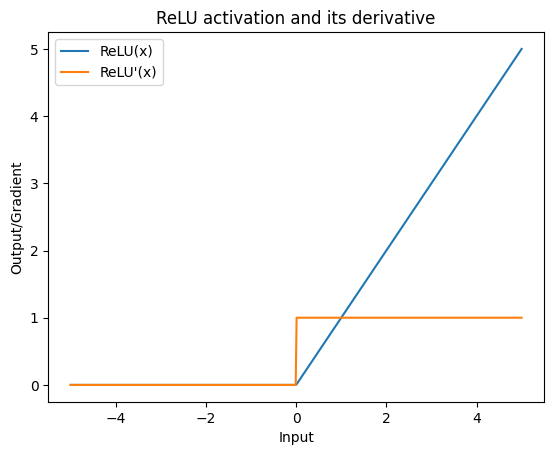

In [46]:
import numpy as np, matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

x = np.linspace(-5, 5, 500)
y = relu(x)
dy = relu_deriv(x)

plt.plot(x, y, label='ReLU(x)')
plt.plot(x, dy, label="ReLU'(x)")
plt.title('ReLU activation and its derivative')
plt.xlabel('Input')
plt.ylabel('Output/Gradient')
plt.legend()
plt.show()



#### *Gaussian Error Linear Units (GELUs) (Hendrycks, Gimpel, 2016)*

Standard nonlinear activations such as ReLU and stochastic regularizers like dropout have
traditionally been treated as independent components: the activation deterministically gates each neuron’s input, while dropout randomly silences units to induce a pseudoensemble effect.  However, Hendrycks & Gimpel (2016) observe that both ReLU and dropout apply a *zero–one mask* to the incoming signal: ReLU sets the mask to $\mathbf{1}\{x>0\}$ deterministically, whereas dropout samples from $\mathrm{Bernoulli}(p)$ irrespective of the input magnitude. GELU merges these operations into a single, input‐dependent stochastic gating function, so that each neuron’s output reflects both its instantaneous value and the probability it should remain active under noise.

Formally, let $x\in\mathbb{R}$ be a pre‐activation.  GELU proposes to multiply $x$ by a random binary mask
$$
m \sim \mathrm{Bernoulli}\bigl(\Phi(x)\bigr)
$$
where
$$
\Phi(x) \;=\; \int_{-\infty}^x \frac{1}{\sqrt{2\pi}}e^{-t^2/2}\,dt
$$
is the cumulative distribution function of the standard normal distribution.  Intuitively, larger values of $x$ are more likely to be “kept”, imparting a smooth, probabilistic gating that depends on the neuron’s strength.  Taking the *expected value* of this stochastic process yields the deterministic GELU activation:
$$
\mathrm{GELU}(x)
=
\mathbb{E}\bigl[x\,m\bigr]
=
x\,\Phi(x)
$$
Because neuron inputs in deep networks often approximate Gaussian distributions—particularly when combined with BatchNorm, using the normal CDF aligns the activation’s gating probability with the actual input statistics.

Although the exact CDF is straightforward to implement, it is common to use a fast, accurate approximation:
$$
\mathrm{GELU}(x)
\approx
x \cdot \tfrac{1}{2}\bigl[1 + \tanh\bigl(\sqrt{\tfrac{2}{\pi}}\,(x + 0.044715\,x^3)\bigr)\bigr],
$$

By fusing stochastic regularization and activation into a single, input-dependent operation, GELU offers a principled means of inducing pseudoensemble behavior *within* each nonlinear layer.  Empirically, Transformer variants that adopt GELU in place of ReLU can achieve faster convergence and often higher final accuracy across language modeling and translation benchmarks. suggesting that this tighter coupling between activation and regularization is beneficial in practice (Hendrycks & Gimpel, 2016).


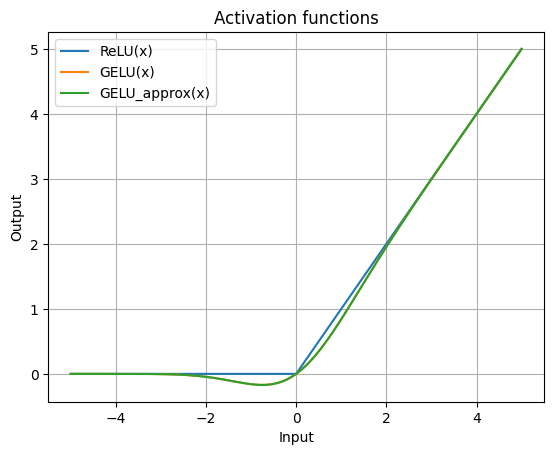

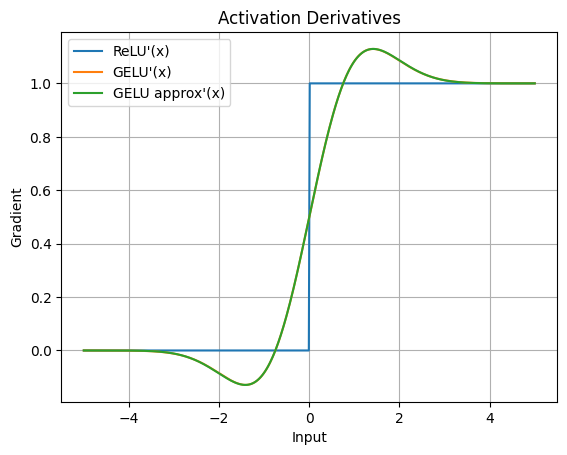

In [47]:
from math import erf, sqrt

erf_vec = np.vectorize(erf)

def gelu(x):
    return 0.5 * x * (1 + erf_vec(x / sqrt(2)))

def gelu_approx(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * (x**3))))

x = np.linspace(-5, 5, 500)
plt.figure()
plt.plot(x, relu(x), label='ReLU(x)')
plt.plot(x, gelu(x), label='GELU(x)')
plt.plot(x, gelu_approx(x), label='GELU_approx(x)')
plt.title('Activation functions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
dy_gelu = np.gradient(gelu(x), x)
dy_gelu_approx = np.gradient(gelu_approx(x), x)
plt.plot(x, dy, label="ReLU'(x)")
plt.plot(x, dy_gelu, label="GELU'(x)")
plt.plot(x, dy_gelu_approx, label="GELU approx'(x)")
plt.title("Activation Derivatives")
plt.xlabel("Input")
plt.ylabel("Gradient")
plt.legend()
plt.grid(True)
plt.show()



Note how the smoothness of GELU allows for a small, non-zero output for negative values, which are allowed to contribute to the learning process (although to a reduced extent when compared to positive inputs). Indeed, as can be seen from the graph below, from *PapersWithCode*, the use of GELU is now more frequent than ReLU in contexts of research and findings publication, reflecting the fact that, in LLMs, GELU and similar-gated linear units offer improved performance.

|                     ![Usage Over Time of Activation Functions](../images/reluvsgelu.png)                     |
|:---------------------------------------------------------------------------------------------------------:|
| Proportion of papers using different activation functions  (*Rectified Linear Units*, **PapersWithCode**) |

In [48]:
class GELU(nn.Module):
    """
    Use the tanh-based approximation for efficiency.
    """
    def __init__(self):
        super().__init__()
        # we precompute constants to avoid repeated tensor allocations
        self._sqrt_2_over_pi = torch.sqrt(torch.tensor(2.0 / torch.pi))
        self._coef = 0.044715


    def forward(self, x):
        return 0.5 * x * (
                1.0 + torch.tanh(self._sqrt_2_over_pi * (x + self._coef * x.pow(3))
                                 )
        )

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_model = cfg.emb_dim
        d_ff = 4 * d_model
        self.layers = nn.Sequential(
            nn.Linear(d_model, d_ff),
            GELU(),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        return self.layers(x)

Note that, although the input and output dimensions of the FeedForward module are the same, it expands (through a hidden layer) the embedding dimension through the first layer, and then contracts again in the second linear layer. The goal with the expansion and contraction is to internally explore a richer and more vast representational space.

|                                                              ![Multilayer Feed-Forward Neural Networks](../images/hidden_layer.png)                                                               |
|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Internal expansion of the representational space through hidden layer (*Predicting daily return direction of the stock market using hybrid machine learning algorithms*, **Zhong, Enke 2020**) |

### Shortcut Connections
Shortcut connections, also called skip or residual connections, were originally proposed by Kaiming He et al. (2015, *Deep Residual Learning for Image Recognition*) to tackle the problem of degradation and vanishing gradients. In the context of computer vision, it was clear that depth was of crucial importance, as deep networks integrated and were able to capture low/mid/high level features thanks to a number of stacked, sequential layers. However, it was not so clear if stacking more layers always yielded better networks, namely due to the vanishing/exploding gradients problem. Fortunately, this problem was partly addressed by normalized initialization (choosing weights so that activations/gradients have roughly constant variance across layers) and intermediate normalization layers (BatchNorm, LayerNorm). However, even when deeper networks were able to start converging with the normalization layers in place, a degradation problem was exposed. Vanishing/exploding gradients were mostly solved, but accuracy was observed to rapidly decrease as depth went beyond some point.
> Note that the observed degradation of accuracy came along with higher training error, indicating that degradation was not a result of overfitting. Both train and test error go up.

This degradation was a surprising phenomenon. If we take a well-trained $N$-layer network, and then build an ($N + k$)-layer network by simply inserting $k$ layers computing exactly the identity (i.e. $\mathcal{F}(x) = x$) and copying all other weights, we would expect this deeper net to at least reproduce the shallower net's function, and therefore its training error. However, in practice, standard nonlinear layers can't automatically learn to behave like identity. Solvers are unable to find parameters that are as good as the original $N$-layer solution.

The fix He et al. found was to make that identity explicit. If deep networks aimed to learn a complex transformation $H(x)$ mapping an input vector $x$ to a desired output representation, then directly fitting $H(x)$ via a stack of nonlinear layers becomes increasingly difficult due to already mentioned optimization challenges. Rather than having each block of layers attempt to approximate $H(x)$ outright, we introduce a *residual* function:
$$
F(x) := H(x) - x
$$
The original mapping can then be expressed as $H(x) = F(x) + x$.

$F(x)$ captures how the desired mapping differs from the identity transform. If the optimal transformation is close to merely passing its input through unchanged, then forcing $F(x)$ to be zero is far more simple than coercing a deep stack of nonlinearities to replicate an identity mapping. This approach makes the identity map $y=x$ always available by setting $F(x) = 0$, and also improves gradient flow by preventing gradients from vanishing/exploding across many layers (since gradients now flow both through the residual branch and directly through the identity path).

|                          ![Residual Learning Block](../images/reslearning.png)                          |
|:----------------------------------------------------------------------------------------------------:|
| An example of residual learning (*Deep Residual Learning for Image Recognition*, **He et.al, 2015**) |


In [49]:
# define the example network with optional shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            if self.use_shortcut and out.shape == x.shape:
                x = x + out
            else:
                x = out
        return x

In [50]:
torch.manual_seed(0)
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

#utility to zero gradients, do a forward+backward pass, and print mean [grad] for each weight.
def print_gradients(model, x):
    model.zero_grad()
    output = model(x)
    loss = nn.MSELoss()
    loss = loss(output, torch.zeros_like(output))
    loss.backward()
    print(f"\nGradients for model (use_shortcut={model.use_shortcut}):")
    for name, param in model.named_parameters():
        if 'weight' in name:
            mean_grad = param.grad.abs().mean().item()
            print(f" {name:25s} mean(abs(grad)) = {mean_grad:.6e}")

In [51]:
print_gradients(model_without_shortcut, sample_input)


Gradients for model (use_shortcut=False):
 layers.0.0.weight         mean(abs(grad)) = 2.174250e-03
 layers.1.0.weight         mean(abs(grad)) = 1.820165e-03
 layers.2.0.weight         mean(abs(grad)) = 2.398570e-03
 layers.3.0.weight         mean(abs(grad)) = 1.912503e-02
 layers.4.0.weight         mean(abs(grad)) = 2.637607e-01


In [52]:
print_gradients(model_with_shortcut, sample_input)


Gradients for model (use_shortcut=True):
 layers.0.0.weight         mean(abs(grad)) = 2.480292e-01
 layers.1.0.weight         mean(abs(grad)) = 3.982194e-01
 layers.2.0.weight         mean(abs(grad)) = 3.303533e-01
 layers.3.0.weight         mean(abs(grad)) = 3.638376e-01
 layers.4.0.weight         mean(abs(grad)) = 2.195423e+00


|                                   ![Shortcut Connection Comparison](../images/resvsnon_res.png)                                   |
|:------------------------------------------------------------------------------------------------------------------------------:|
| Deep neural network without (left) and with (right) shortcut connections (*Build a LLM (From Scratch)*, **Sebastian Raschka**) |

As can be seen from the results above, the gradients from the network without shortcut connections become smaller and smaller as we move from the deepest layer to the first one. In other words, we are seeing the vanishing gradient problem. In the network with shortcut connections, although the gradient of the deepest layer is still the largest, the gradient does not shrink to near-zero, extremely small values. In this way, shortcut connections help make training more effective by ensuring consistent, stable gradients as these flow between layers.

### Transformer Blocks: Connecting everything

|              ![Transformer Block Illustration](../images/transformer_block.png)              |
|:-----------------------------------------------------------------------------------------:|
| Illustration of a transformer block (*Build a LLM (From Scratch)*, **Sebastian Raschka**) |

A Transformer block unites several core components--multi-head self-attention, position-wise feed-forward networks, residual mappings, layer normalization and non-linear activations--into a single, repeatable unit. This design makes it possible to build very deep language models that learn both long-range dependencies and rich intra-token representations while remaining relatively easy to optimize. As can be seen from the illustration above, each element of the input sequence (a word, a subword, a BPE unit) is first mapped to a $d$-dimensional embedding vector (in this case, 768 dimensions). Every single sublayer in the block, whether it is attention, a feed-forward transform, a residual add or normalization, accepts and emits vectors of the same dimension $d$. Preserving this 'model width' serves many purposes:

- Enables residual addition, since otherwise the addition would be undefined.
- Simplifies stacking, since blocks can be tiled arbitrarily without reshaping or re-projection, drastically easing both implementation and parameter bookkeeping.
- Every token is processed identically, sharing the same parameters and sublayer structure. This enforces translational invariance across sequence positions, ensuring that the model learns positional relationships rather than position-specific filters.

Note that attention and feed-forward networks play complementary roles. Self-attention excels at modeling interactions across the entire sequence, identifying which other tokens should influence the current one. Feed-forward networks inject powerful nonlinear transformations within each token's feature vector. By alternating a global, linear mixing stage with a local, nonlinear processing stage, the block achieves both broad contextual awareness and deep per-token feature extraction.


In [53]:
from src.attention import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg: GPTConfig124):
        super().__init__()
        # 1) multi-head self-attention sublayer implemented before
        self.att = MultiHeadAttention(
            d_in = cfg.emb_dim,
            d_out = cfg.emb_dim,
            context_length = cfg.context_length,
            num_heads = cfg.n_heads,
            dropout_rate = cfg.dropout,
            qkv_bias = cfg.qkv_bias)
        # 2) position-wise feed-forward layer
        self.ff = FeedForward(cfg)
        # 3) pre-norm layernorms
        self.norm1 = LayerNorm(cfg.emb_dim)
        self.norm2 = LayerNorm(cfg.emb_dim)
        # 4) dropout on the residual connection
        self.drop_shortcut = nn.Dropout(cfg.dropout)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x) # normalize before attention (pre-norm)
        x = self.att(x) # (batch_size, seq_len, d)
        x = self.drop_shortcut(x)
        x = x + shortcut # residual

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x) # two-layer MLP with activation & dropout
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [54]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
cfg = GPTConfig124()
block = TransformerBlock(cfg)
output = block(x)

print('Input shape:', x.shape)
print('Output shape:', output.shape)


Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


We now have implemented all the components necessary to implement our own GPT model.

In [55]:
class GPTModel(nn.Module):
    def __init__(self, cfg: GPTConfig124):
        super().__init__()
        # token embedding: from vocab indices to vectors
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.emb_dim)
        # learnable per-position vectors
        self.pos_emb = nn.Embedding(cfg.context_length, cfg.emb_dim)
        self.drop_emb = nn.Dropout(cfg.dropout)
        # a stack of transformer blocs
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg.n_layers)]
        )

        # final layer norm before head
        self.final_form = LayerNorm(cfg.emb_dim)
        # ourput head (maps back to vocab logits)
        self.out_head = nn.Linear(cfg.emb_dim, cfg.vocab_size, bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        # first, lookup token indices -> (batch_size, seq_len, D)
        tok_embeds = self.tok_emb(in_idx)
        # create position indices 0..T-1 -> (T,) then embed -> (T, D)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        # add dropout and run through transformer stack
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        # final form and linear head --> logits (B, T, V)
        x = self.final_form(x)
        logits = self.out_head(x)
        return logits



In [56]:
torch.manual_seed(123)
cfg = GPTConfig124()
cfg = GPTModel(cfg)
out = model(batch[0])
print('Input batch:', batch[0])
print('Output shape:', out.shape)
print(out)

Input batch: tensor([[  32,  582, 1297,  502],
        [1752,  326,  477,  262]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.2409,  0.1311,  0.2402,  ..., -0.4997, -0.1644,  0.9696],
         [-0.2041,  0.7288, -1.2760,  ...,  0.0939,  0.1340,  0.3174],
         [ 0.6621,  0.2406,  0.2999,  ...,  1.3145,  0.8154,  0.2830],
         [ 0.4244,  0.3555, -0.5786,  ...,  1.3489,  0.4234, -0.0844]],

        [[-0.0234, -0.9365, -0.3012,  ...,  0.3798, -0.3834, -0.2383],
         [-0.9749,  0.9371, -0.6656,  ..., -0.6975,  0.3701,  1.2825],
         [ 0.0169,  0.7391,  0.1087,  ...,  1.7415, -0.1239, -0.6415],
         [-0.0867, -0.0894, -0.3219,  ...,  2.0153, -0.2922,  0.0603]]],
       grad_fn=<UnsafeViewBackward0>)


In [57]:
total_tunable_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {total_tunable_params}')

Number of parameters: 77981184
